In [1]:
import wandb
import yaml
from utils import correct_type_of_entry
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [26]:
dataset = "mnist"
#[0, 1, 2, 4, 5, -1]
#[8, 7, 3, 9, 6, -1]
first_class = 2
second_class = 3
sweep_config = "default"
values_to_fetch = ['kl_bound', 'binomial_approximation_shah', 'p2l_bound', 'compression_set_size', 'val_error', 'test_error']

In [27]:
sweep_config_name = "./configs/sweep_configs/" + sweep_config + ".yaml"
with open(sweep_config_name) as file:
    sweep_configuration = yaml.safe_load(file)
    
hps = {}
for key, item in sweep_configuration['parameters'].items():
    if item.get('values', None) is not None:
        hps[key] = correct_type_of_entry(item['values'])
size_hyperparams = tuple([len(l) for l in hps.values()])

In [28]:
api = wandb.Api()
entity = "mathieu-bazinet"
project = "sweep" + dataset + str(first_class) + str(second_class)
runs = api.runs(entity + "/" + project)

In [29]:
results_matrix = np.ones(((len(values_to_fetch),) + size_hyperparams))

for run_idx in range(len(runs)):
    run = runs[run_idx]
    for val_to_fetch_idx in range(len(values_to_fetch)):
        matrix_idx = tuple([val_to_fetch_idx] + [hps[key].index(run.config[key]) for key in hps.keys()])
        val_to_fetch = values_to_fetch[val_to_fetch_idx]
        results_matrix[matrix_idx] = run.summary[val_to_fetch]

In [30]:
from itertools import product

hp_list = list(hps.values())[1:]
params_product = list(product(*hp_list))
name_list = []
idx_list = []
for params in params_product:
    name = ""
    for p in params:
        name += str(p) + " "
    name_list.append(name[:-1])
    idx = ()
    for p_idx in range(len(params)):
        p_key = list(hps.keys())[1:][p_idx]
        idx += (hps[p_key].index(params[p_idx]),)
    idx_list.append(tuple(idx))

def different_length_means(list_of_list):
    mean_list = []
    for idx in range(max([len(l) for l in list_of_list])):
        count = 0
        somme = 0
        for l in list_of_list:
            if len(l) > idx:
                somme += l[idx]
                count += 1
        mean_list.append(somme/count)
    return np.array(mean_list)

In [31]:
reshaped_matrix = results_matrix.mean(1).reshape(results_matrix.shape[0],np.prod(results_matrix.shape[2:])).T
mean_df = pd.DataFrame(reshaped_matrix, index=name_list, columns=values_to_fetch)
mean_df

,kl_bound,binomial_approximation_shah,p2l_bound,compression_set_size,val_error,test_error
mlp 0.1 0.01,0.154598,0.154169,0.041498,408.4,0.008362,0.004785
mlp 0.1 0.001,0.139335,0.138900,0.036207,354.2,0.009574,0.006383
mlp 0.1 0.005,0.145953,0.145520,0.038492,377.6,0.010337,0.004715
mlp 0.1 0.0001,0.130760,0.130321,0.033365,325.2,0.012104,0.006998
mlp 0.2 0.01,0.185745,0.185326,0.053105,528.0,0.008256,0.005747
mlp 0.2 0.001,0.136646,0.136210,0.035306,345.0,0.008817,0.003718
mlp 0.2 0.005,0.145119,0.144686,0.038181,374.4,0.009750,0.005642
mlp 0.2 0.0001,0.122146,0.121704,0.030558,296.6,0.008667,0.005751
cnn 0.1 0.01,0.117436,0.116992,0.029062,281.4,0.005877,0.002521
cnn 0.1 0.001,0.082042,0.081585,0.018583,175.8,0.004835,0.002574


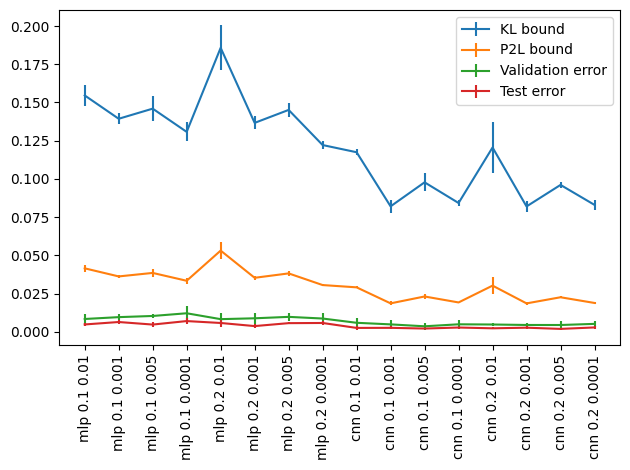

In [32]:
std_matrix = results_matrix.std(1).reshape(results_matrix.shape[0],np.prod(results_matrix.shape[2:])).T
std_df = pd.DataFrame(std_matrix, index=name_list, columns=values_to_fetch)

plt.errorbar(x=name_list,
             y=mean_df['kl_bound'],
             yerr=std_df['kl_bound'],
             # marker="o",
             label="KL bound")
plt.errorbar(x=name_list,
             y=mean_df['p2l_bound'],
             yerr=std_df['p2l_bound'],
             # marker="o",
             label="P2L bound")
plt.errorbar(x=name_list,
             y=mean_df['val_error'],
             yerr=std_df['val_error'],
             # marker="o",
             label="Validation error")
plt.errorbar(x=name_list,
             y=mean_df['test_error'],
             yerr=std_df['test_error'],
             # marker="o",
             label="Test error")
plt.xticks(rotation=90)
plt.legend()
plt.tight_layout()
plt.savefig(f"./results/{dataset}_{first_class}_{second_class}_comparison_of_bounds.jpg")

In [33]:
runs[0].history()['complement_error'][~runs[0].history()['complement_error'].isna()] # does the same thing as next run

history = runs[0].scan_history(keys=["complement_error"])
losses = [row["complement_error"] for row in history]
losses

[0.4561530649662018,
 0.403522789478302,
 0.20084340870380402,
 0.20315149426460266,
 0.1511901468038559,
 0.05130103603005409,
 0.04055815562605858,
 0.026881679892539978,
 0.009928615763783455,
 0.00990875344723463,
 0.008716811425983906,
 0.004343862645328045,
 0.0015824898146092892,
 0.0018994152778759599,
 0.001192938769236207,
 0.0007524820393882692,
 0.0006787251331843436,
 0]

In [34]:
# runs[0].config
runs[0].config['data_groupsize'] * runs[0].config['log_iterations']
# runs[0].summary['compression_set_size']
val_sizes = runs[0].config['data_groupsize'] * runs[0].config['log_iterations']
# np.array(list(range(len(losses)))) * val_sizes
runs[0].config['delta']

0.01

The best bound for run 42 happens at 90 datapoints with a bound value of 0.08706379932024422
The best bound for run 4 happens at 120 datapoints with a bound value of 0.07470446353478843
The best bound for run 3 happens at 80 datapoints with a bound value of 0.07830332373763024
The best bound for run 2 happens at 90 datapoints with a bound value of 0.07676475805201817
The best bound for run 1 happens at 100 datapoints with a bound value of 0.08555835779956247
(Mean value) The best bound happens at 180 datapoints with a bound value of 0.09251302466009596


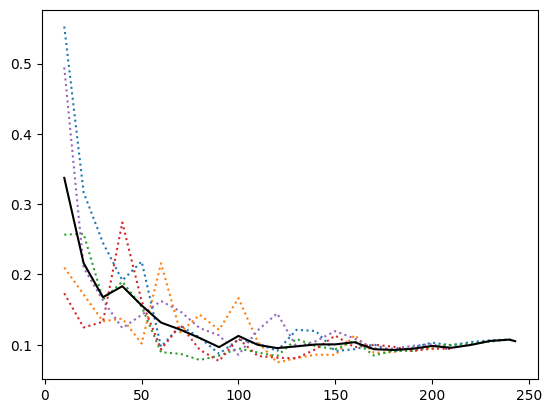

In [35]:
from bounds.real_valued_bounds import compute_epsilon, kl_bound

model_type, dropout_probability, training_lr = correct_type_of_entry(mean_df.index[mean_df['val_error'].argmin()].split())

# model_type = "cnn"
# training_lr = 0.01
# dropout_probability = 0.1

run_list = []

for run in runs:
    if run.config['model_type'] == model_type:
        if run.config['training_lr'] == training_lr:
            if run.config['dropout_probability'] == dropout_probability:
                run_list.append(run)

all_seeds_bounds = []
max_length_run = 0
max_comp_sizes = []
for run in run_list:
    history = run.scan_history(keys=["complement_error"])
    losses = [row["complement_error"] for row in history]
    val_sizes = run.config['data_groupsize'] * run.config['log_iterations']
    compression_sizes = np.array(list(range(1,len(losses)))) * val_sizes
    compression_sizes = np.append(compression_sizes, run.summary['compression_set_size'])

    if compression_sizes.shape[0] > max_length_run:
        max_length_run = compression_sizes.shape[0]
        max_comp_sizes = compression_sizes
        
    bound_list = []
    for idx in range(len(losses)):
        epsilon = compute_epsilon(compression_sizes[idx], 1, run.summary['train_set_size'], run.config['delta'])
        bound = kl_bound(compression_sizes[idx], run.summary['train_set_size'], float(losses[idx]), epsilon)
        bound_list.append(bound)
    plt.plot(compression_sizes, bound_list, linestyle="dotted")
    best_idx = np.array(bound_list).argmin()
    print(f"The best bound for run {run.config['seed']} happens at {compression_sizes[best_idx]} datapoints with a bound value of {bound_list[best_idx]}")
    all_seeds_bounds.append(bound_list)

mean_bounds = different_length_means(all_seeds_bounds)
plt.plot(max_comp_sizes, mean_bounds, color="black")

best_size = max_comp_sizes[mean_bounds.argmin()]
best_error = mean_bounds.min()
print(f"(Mean value) The best bound happens at {best_size} datapoints with a bound value of {best_error}")

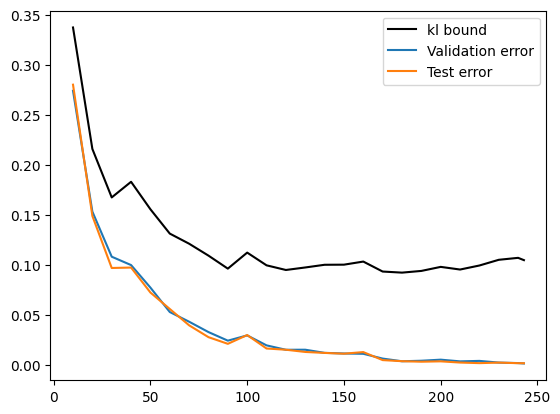

In [36]:
plt.plot(max_comp_sizes, mean_bounds, color="black", label="kl bound")
test_errors = []
val_errors = []
for run in run_list:
    # TO BE REMOVED
    if dataset + str(first_class) + str(second_class) == "mnist49":
        history = run.scan_history(keys=["test_results"])
        test_error = [row["test_results"] for row in history]
        test_error.append(run.summary['test_error'])
        test_errors.append(test_error)
    
    history = run.scan_history(keys=["test_error"])
    test_error = [row["test_error"] for row in history]
    test_errors.append(test_error)
    
    history = run.scan_history(keys=["val_error"])
    val_error = [row["val_error"] for row in history]
    if len(val_error) != len(test_error):
        val_error.append(run.summary['validation_error'])
    val_errors.append(val_error)


mean_val = different_length_means(val_errors)
mean_test = different_length_means(test_errors)
plt.plot(max_comp_sizes, mean_val, label="Validation error")
plt.plot(max_comp_sizes, mean_test, label="Test error")
plt.legend()
plt.show()

In [37]:
run_list

[<Run mathieu-bazinet/sweepmnist23/j6kka6ek (finished)>,
 <Run mathieu-bazinet/sweepmnist23/qwgiiu7s (finished)>,
 <Run mathieu-bazinet/sweepmnist23/htb7bjsi (finished)>,
 <Run mathieu-bazinet/sweepmnist23/e9mg87ib (finished)>,
 <Run mathieu-bazinet/sweepmnist23/vg50d86e (finished)>]